In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, precision_recall_fscore_support
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import math

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train_data = pd.read_csv('issues_test.csv')
test_data = pd.read_csv('issues_train.csv')

In [4]:
# perform pre-processing steps
def preprocess(text):
    if isinstance(text, float) and math.isnan(text):
        return ''
    text = str(text).lower()  
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens if re.sub(r'[^a-zA-Z0-9]', '', token) != '']
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

train_data['title'] = train_data['title'].apply(preprocess)
train_data['body'] = train_data['body'].apply(preprocess)

test_data['title'] = test_data['title'].apply(preprocess)
test_data['body'] = test_data['body'].apply(preprocess)

train_data['text'] = train_data['title'] + ' ' + train_data['body']
test_data['text'] = test_data['title'] + ' ' + test_data['body']


In [5]:
# Loading model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-small')
model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-small').to('cuda')

In [6]:
train_inputs = ['classify: ' + text for text in train_data['text']]
test_inputs = ['classify: ' + text for text in test_data['text']]
train_outputs = [str(label) for label in train_data['label']]
test_outputs = [str(label) for label in test_data['label']]

In [7]:
train_encodings = tokenizer(train_inputs, padding=True, max_length = 512, truncation=True, return_tensors="pt")
test_encodings = tokenizer(test_inputs, padding=True, max_length = 512, truncation=True, return_tensors="pt")

In [8]:
train_labels = tokenizer(train_outputs, padding=True, max_length = 512, truncation=True, return_tensors="pt")["input_ids"]
test_labels = tokenizer(test_outputs, padding=True, max_length = 512, truncation=True, return_tensors="pt")["input_ids"]

In [9]:
# training parameters
batch_size = 32
num_epochs = 25
learning_rate = 2e-5

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(train_encodings["input_ids"]), batch_size):
        batch_inputs = {k: v[i:i+batch_size].to('cuda') for k, v in train_encodings.items()}
        batch_labels = train_labels[i:i+batch_size].to('cuda')
        optimizer.zero_grad()
        outputs = model(**batch_inputs, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

Epoch 1/25, Loss: 169.2258859872818
Epoch 2/25, Loss: 28.921600431203842
Epoch 3/25, Loss: 24.833185628056526
Epoch 4/25, Loss: 23.134217351675034
Epoch 5/25, Loss: 21.734523445367813
Epoch 6/25, Loss: 21.135160222649574
Epoch 7/25, Loss: 20.28599774837494
Epoch 8/25, Loss: 19.30087523162365
Epoch 9/25, Loss: 18.59920271486044
Epoch 10/25, Loss: 17.410355105996132
Epoch 11/25, Loss: 16.744566958397627
Epoch 12/25, Loss: 16.59711115807295
Epoch 13/25, Loss: 15.922862419858575
Epoch 14/25, Loss: 15.096813907846808
Epoch 15/25, Loss: 14.67140862904489
Epoch 16/25, Loss: 14.333802757784724
Epoch 17/25, Loss: 13.524986257776618
Epoch 18/25, Loss: 13.342411713674664
Epoch 19/25, Loss: 11.828345624729991
Epoch 20/25, Loss: 11.610893773846328
Epoch 21/25, Loss: 10.995650901459157
Epoch 22/25, Loss: 10.975131090730429
Epoch 23/25, Loss: 10.455995026044548
Epoch 24/25, Loss: 9.991281744092703
Epoch 25/25, Loss: 9.140636093216017


In [11]:
from sklearn.metrics import classification_report

# Evaluation 
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for i in range(0, len(test_encodings["input_ids"]), batch_size):
        batch_inputs = {k: v[i:i+batch_size].to('cuda') for k, v in test_encodings.items()}
        outputs = model.generate(**batch_inputs)
        predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_preds.extend(predictions)
        all_labels.extend(test_outputs[i:i+batch_size])


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [12]:
from sklearn.metrics import classification_report

# Classification report
label_map = {label: i for i, label in enumerate(train_data['label'].unique())}
valid_preds = [label_map[pred] if pred in label_map else -1 for pred in all_preds]
filtered_preds = [pred for pred in valid_preds if pred != -1]

decoded_labels = [label_map[label] for label in tokenizer.batch_decode(test_labels, skip_special_tokens=True)]

min_length = min(len(decoded_labels), len(filtered_preds))
decoded_labels = decoded_labels[:min_length]
filtered_preds = filtered_preds[:min_length]

# Calculate metrics
report = classification_report(decoded_labels, filtered_preds, output_dict=True)
print(classification_report(decoded_labels, filtered_preds))


              precision    recall  f1-score   support

           0       0.69      0.86      0.77       500
           1       0.83      0.71      0.76       500
           2       0.72      0.64      0.68       500

    accuracy                           0.74      1500
   macro avg       0.75      0.74      0.74      1500
weighted avg       0.75      0.74      0.74      1500



In [14]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

repo_metrics = {}

# Calculate metrics for each repository
for repo in test_data['repo'].unique():  
    mask = test_data['repo'] == repo
    repo_labels = [label_map[label] for label, is_in_mask in zip(test_outputs, mask) if is_in_mask]
    print(f"Number of labels for repository {repo}: {len(repo_labels)}")
    repo_predictions = [filtered_preds[i] for i, is_in_mask in enumerate(mask) if is_in_mask]
    print(f"Number of predictions for repository {repo}: {len(repo_predictions)}")

    
    precision, recall, f1_score, _ = precision_recall_fscore_support(repo_labels, repo_predictions, average=None, labels=np.unique(repo_predictions))
    
    if len(precision) < 3:
        precision = np.append(precision, 0)  
        recall = np.append(recall, 0) 
        f1_score = np.append(f1_score, 0) 
    
    avg_precision, avg_recall, avg_f1_score, _ = precision_recall_fscore_support(repo_labels, repo_predictions, average='weighted')
    
    repo_metrics[repo] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1_score': avg_f1_score
    }

for repo, metrics in repo_metrics.items():
    print(f"\nMetrics for Repository: {repo}")
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1-score:", metrics['f1_score'])
    print("Average Precision:", metrics['avg_precision'])
    print("Average Recall:", metrics['avg_recall'])
    print("Average F1-score:", metrics['avg_f1_score'])


Number of labels for repository facebook/react: 300
Number of predictions for repository facebook/react: 300
Number of labels for repository tensorflow/tensorflow: 300
Number of predictions for repository tensorflow/tensorflow: 300
Number of labels for repository microsoft/vscode: 300
Number of predictions for repository microsoft/vscode: 300
Number of labels for repository bitcoin/bitcoin: 300
Number of predictions for repository bitcoin/bitcoin: 300
Number of labels for repository opencv/opencv: 300
Number of predictions for repository opencv/opencv: 300

Metrics for Repository: facebook/react
Precision: [0.91836735 0.84931507 0.65116279]
Recall: [0.9  0.62 0.84]
F1-score: [0.90909091 0.71676301 0.73362445]
Average Precision: 0.8062817353765336
Average Recall: 0.7866666666666666
Average F1-score: 0.7864927896732425

Metrics for Repository: tensorflow/tensorflow
Precision: [0.80327869 0.90588235 0.8172043 ]
Recall: [0.98 0.77 0.76]
F1-score: [0.88288288 0.83243243 0.78756477]
Average 

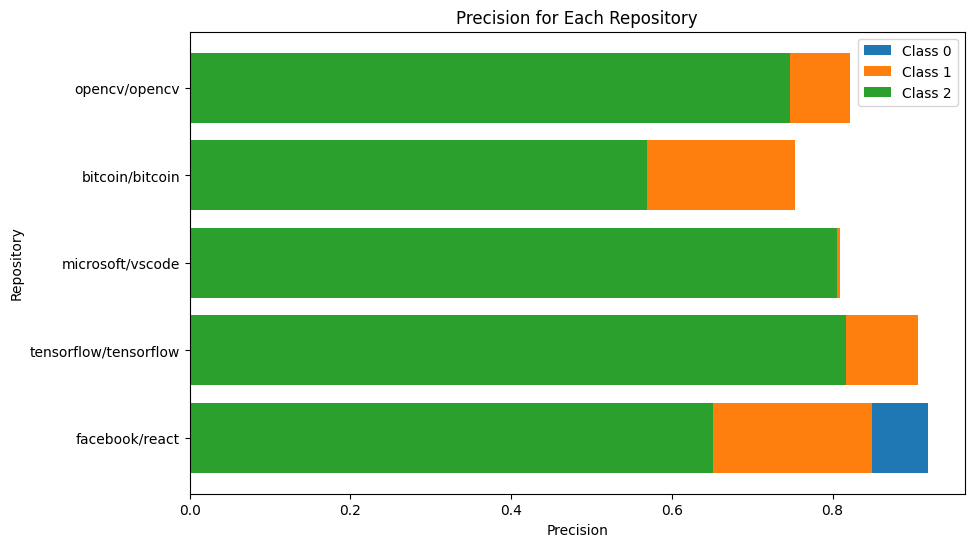

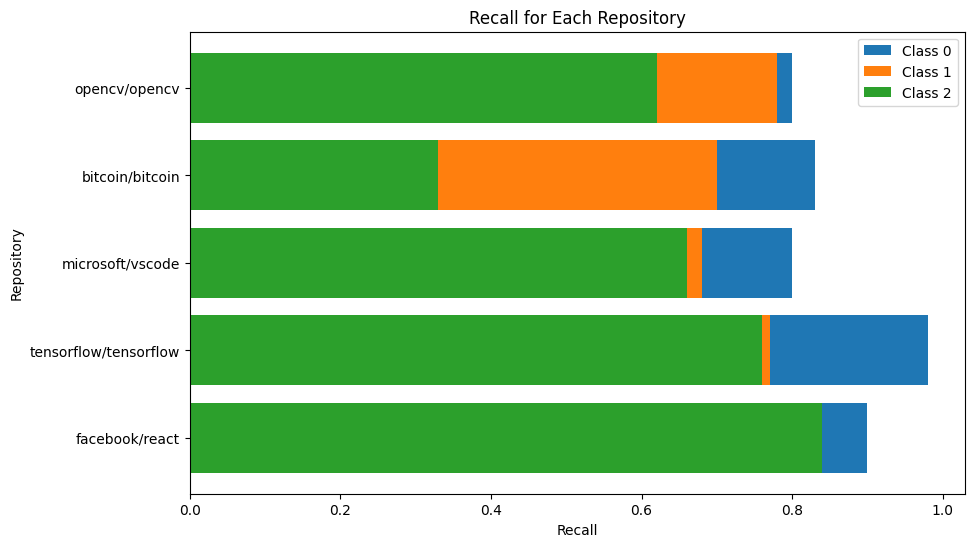

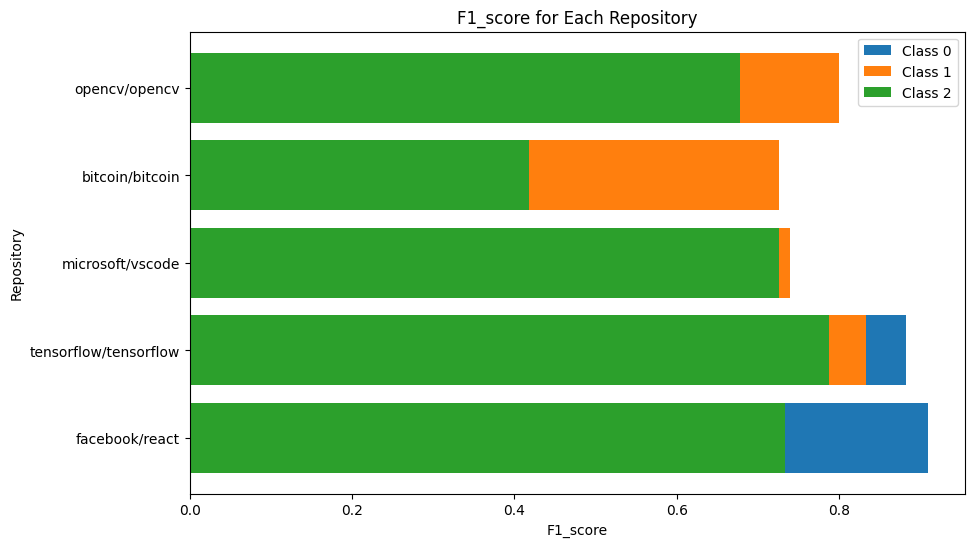

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# visualization of precision, recall and f1-score
def plot_metrics(repo_metrics, metric_name):
    repositories = list(repo_metrics.keys())
    metric_values = [metrics[metric_name] for metrics in repo_metrics.values()]
    metric_values = np.array(metric_values)
    
    plt.figure(figsize=(10, 6))
    for i, class_metric in enumerate(metric_values.T):  
        plt.barh(repositories, class_metric, label=f'Class {i}') 
    
    plt.xlabel(metric_name.capitalize())
    plt.ylabel('Repository')
    plt.title(f'{metric_name.capitalize()} for Each Repository')
    plt.legend()
    plt.show()

plot_metrics(repo_metrics, 'precision')
plot_metrics(repo_metrics, 'recall')
plot_metrics(repo_metrics, 'f1_score')


In [16]:
model.save_pretrained('t5-code')

In [18]:
import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer
import time

model_path = '/home/codegen_inference/t5-code'
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-small')

In [20]:
input_text = "please test using latest version relevant react package make sure issue already fixed react version 1830canary493f72b0a20230727 step reproduce 1 run following code j import reactdomserver reactdomserver const element html head meta title hoisted meta charset utf8 title title title script tag hoisted script src foo script hoisted script src foo async script head html consolelog reactdomserverrendertostring element bug get fixed much faster run code doesnt dependency react issue without reproduction step code example may immediately closed actionable link code example http codesandboxiosreact1830canary493f72b0a20230727ssrhoistbuglvhj45 filesrcindexjs please provide codesandbox http codesandboxiosnew link repository github provide minimal code example reproduces problem may provide screenshot application think relevant bug report tip providing minimal example http stackoverflowcomhelpmcve current behavior consolelog output meta charset utf8 script src foo async script title title title html head script src foo script head html expected behavior consolelog output html head meta charset utf8 title title title script src foo script script src foo async script head html."

inputs = tokenizer(input_text, return_tensors="pt")

start_time = time.time()
with torch.no_grad():
    outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=50)
inference_time = time.time() - start_time

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated response:", response)
print("Inference time:", inference_time, "seconds")


Generated response: bug
Inference time: 0.7045149803161621 seconds
